# Import all module

In [1]:
import os  # For interacting with the operating system (e.g., file paths)
import pandas as pd  # For loading and manipulating CSV data (bounding boxes and image info)
import yaml
import shutil
import numpy as np  # For numerical operations and array handling
import cv2  # For image processing and manipulation (OpenCV library)
import matplotlib.pyplot as plt  # For visualizing data and images (plots)
import seaborn as sns  # For advanced data visualization (especially histograms and distributions)
from glob import glob  # For finding all image files in a directory (using wildcard patterns)
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from PIL import Image
from ultralytics import YOLO


import warnings
warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated")

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████████| 112M/112M [00:06<00:00, 18.8MB/s]

Extracting files...


Path to dataset files: C:\Users\ervin\.cache\kagglehub\datasets\sshikamaru\car-object-detection\versions\2


In [2]:
# Create necessary directories
# !mkdir -p "./kaggle/working/data"
# !mkdir -p "./kaggle/working/data/images"
# !mkdir -p "./kaggle/working/data/images/train"
# !mkdir -p "./kaggle/working/data/images/val"
# !mkdir -p "./kaggle/working/data/labels"
# !mkdir -p "./kaggle/working/data/labels/train"
# !mkdir -p "./kaggle/working/data/labels/val"

root_dir = "./kaggle/working/data"
labels_dir = "./kaggle/working/data/labels"
images_dir = "./kaggle/working/data/images"

train_data = r"./kaggle/versions/2/data/training_images"
csv_data = r"./kaggle/versions/2/data/train_solution_bounding_boxes (1).csv"
test_data = r"./kaggle/versions/2/data/testing_images"

In [3]:
# Loading the CSV data
df = pd.read_csv(csv_data)

# Display the first few rows of the dataframe to understand its structure
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


# Visualizing sample images

In [4]:
# Visualizing sample images with bounding boxes
def plot_images_with_boxes(image_path, df, n=5):
    images = glob(f'{image_path}/*.jpg')[:n]
    for img_path in images:
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        boxes = df[df['image'] == img_name]  # تغيير 'filename' إلى 'image'

        for _, box in boxes.iterrows():
            cv2.rectangle(img,
                          (int(box['xmin']), int(box['ymin'])),
                          (int(box['xmax']), int(box['ymax'])),
                          (0, 255, 0), 2)

        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(img_name)
        plt.axis('off')
        plt.show()

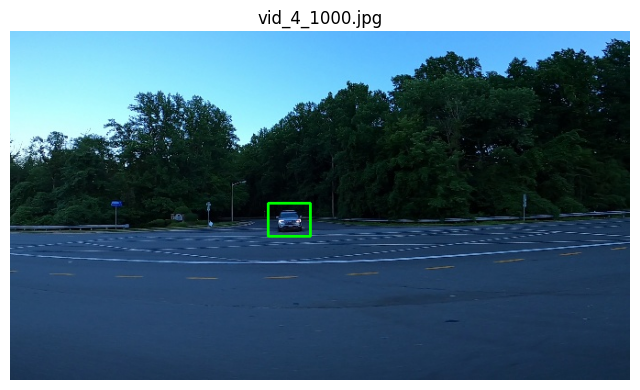

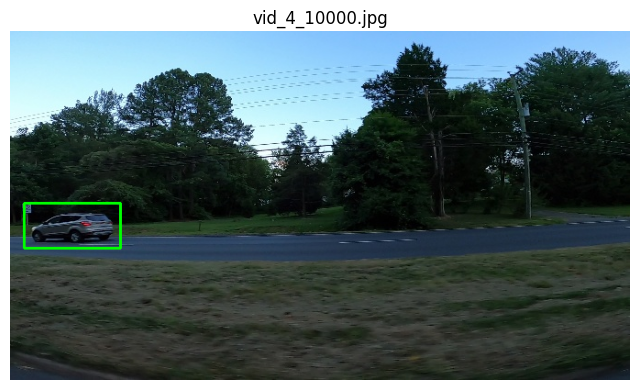

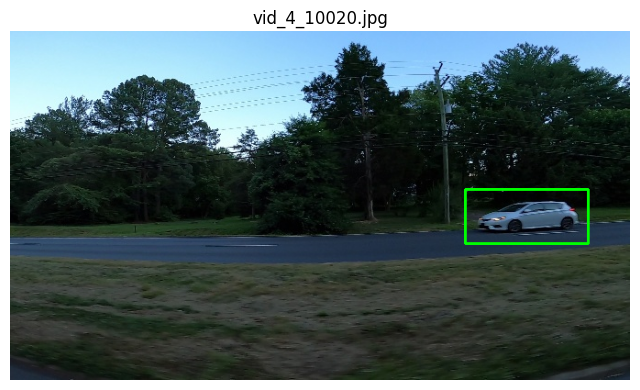

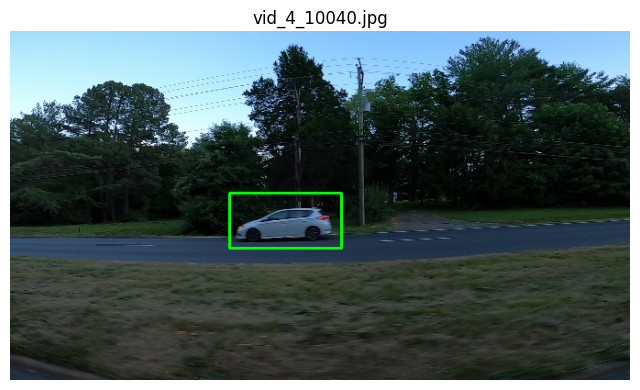

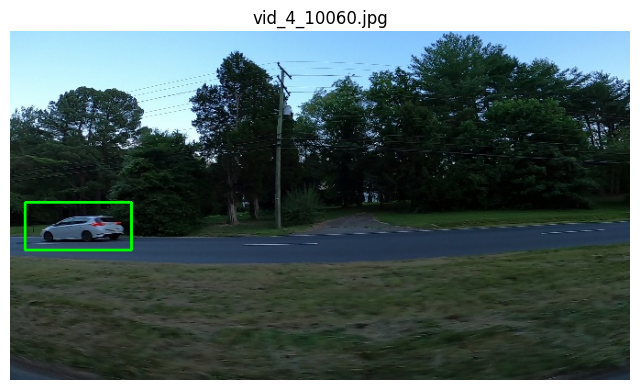

In [5]:
plot_images_with_boxes(train_data, df)

# Preprocessing Data

In [6]:
def voc_to_yolo(size, box):
    img_width, img_height = size
    xmin, ymin, xmax, ymax = box

    # Calculate center coordinates
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0

    # Calculate box dimensions
    box_width = xmax - xmin
    box_height = ymax - ymin

    # Normalize coordinates
    normalized_center_x = center_x / img_width
    normalized_center_y = center_y / img_height
    normalized_box_width = box_width / img_width
    normalized_box_height = box_height / img_height

    # Class ID is 0 for 'car'
    class_id = 0

    return (class_id, normalized_center_x, normalized_center_y, normalized_box_width, normalized_box_height)

In [7]:
# Get a list of all unique image filenames
unique_images = df['image'].unique()

# Loop through each unique image filename
for image_name in unique_images:
    image_boxes = df[df['image'] == image_name]

In [8]:
# Get a list of all unique image filenames
unique_images = df['image'].unique()

# Loop through each unique image filename
for image_name in unique_images:
    image_boxes = df[df['image'] == image_name]

    image_path = os.path.normpath(os.path.join(train_data, image_name))

    img = cv2.imread(image_path)

    img_height, img_width, _ = img.shape

    image_size = (img_width, img_height)

    print(f"Processing image: {image_name} with dimensions: {image_size}")

Processing image: vid_4_1000.jpg with dimensions: (676, 380)
Processing image: vid_4_10000.jpg with dimensions: (676, 380)
Processing image: vid_4_10040.jpg with dimensions: (676, 380)
Processing image: vid_4_10020.jpg with dimensions: (676, 380)
Processing image: vid_4_10060.jpg with dimensions: (676, 380)
Processing image: vid_4_10100.jpg with dimensions: (676, 380)
Processing image: vid_4_10120.jpg with dimensions: (676, 380)
Processing image: vid_4_10140.jpg with dimensions: (676, 380)
Processing image: vid_4_1020.jpg with dimensions: (676, 380)
Processing image: vid_4_1040.jpg with dimensions: (676, 380)
Processing image: vid_4_10480.jpg with dimensions: (676, 380)
Processing image: vid_4_10500.jpg with dimensions: (676, 380)
Processing image: vid_4_10520.jpg with dimensions: (676, 380)
Processing image: vid_4_1060.jpg with dimensions: (676, 380)
Processing image: vid_4_10960.jpg with dimensions: (676, 380)
Processing image: vid_4_10980.jpg with dimensions: (676, 380)
Processing i

In [9]:
# Get a list of all unique image filenames
unique_images = df['image'].unique()

# Loop through each unique image filename
for image_name in unique_images:
    image_boxes = df[df['image'] == image_name]

    image_path = os.path.join(train_data, image_name)

    img = cv2.imread(image_path)

    img_height, img_width, _ = img.shape

    annotation_filename = image_name.replace('.jpg', '.txt')
    annotation_path = os.path.join(labels_dir, 'train', annotation_filename)

    with open(annotation_path, 'w') as f:
        for _, box in image_boxes.iterrows():
            xmin, ymin, xmax, ymax = box[['xmin', 'ymin', 'xmax', 'ymax']]

            yolo_coords = voc_to_yolo((img_width, img_height), (xmin, ymin, xmax, ymax))

            yolo_string = f"{yolo_coords[0]} {yolo_coords[1]:.6f} {yolo_coords[2]:.6f} {yolo_coords[3]:.6f} {yolo_coords[4]:.6f}\n"

            f.write(yolo_string)

    print(f"Generated YOLO annotation for {image_name} at {annotation_path}")

Generated YOLO annotation for vid_4_1000.jpg at ./kaggle/working/data/labels\train\vid_4_1000.txt
Generated YOLO annotation for vid_4_10000.jpg at ./kaggle/working/data/labels\train\vid_4_10000.txt
Generated YOLO annotation for vid_4_10040.jpg at ./kaggle/working/data/labels\train\vid_4_10040.txt
Generated YOLO annotation for vid_4_10020.jpg at ./kaggle/working/data/labels\train\vid_4_10020.txt
Generated YOLO annotation for vid_4_10060.jpg at ./kaggle/working/data/labels\train\vid_4_10060.txt
Generated YOLO annotation for vid_4_10100.jpg at ./kaggle/working/data/labels\train\vid_4_10100.txt
Generated YOLO annotation for vid_4_10120.jpg at ./kaggle/working/data/labels\train\vid_4_10120.txt
Generated YOLO annotation for vid_4_10140.jpg at ./kaggle/working/data/labels\train\vid_4_10140.txt
Generated YOLO annotation for vid_4_1020.jpg at ./kaggle/working/data/labels\train\vid_4_1020.txt
Generated YOLO annotation for vid_4_1040.jpg at ./kaggle/working/data/labels\train\vid_4_1040.txt
Genera

In [10]:
# Get a list of all unique image filenames
unique_images = df['image'].unique()

# Split the unique image filenames into training and validation sets
train_images, val_images = train_test_split(unique_images, test_size=0.2, random_state=42)

print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")

Number of training images: 284
Number of validation images: 71


In [11]:
# Organize training images and labels
for image_name in train_images:
    # Copy image
    src_image_path = os.path.join(train_data, image_name)
    dest_image_path = os.path.join(images_dir, 'train', image_name)
    shutil.copyfile(src_image_path, dest_image_path)

# Organize validation images and labels
for image_name in val_images:
    src_image_path = os.path.join(train_data, image_name)
    dest_image_path = os.path.join(images_dir, 'val', image_name)
    shutil.copyfile(src_image_path, dest_image_path)

    # Copy label from train labels directory to val labels directory
    annotation_filename = image_name.replace('.jpg', '.txt')
    src_annotation_path = os.path.join(labels_dir, 'train', annotation_filename)
    dest_annotation_path = os.path.join(labels_dir, 'val', annotation_filename)
    shutil.copyfile(src_annotation_path, dest_annotation_path)

print("Image and label files organized into train and validation directories.")

Image and label files organized into train and validation directories.


In [12]:
# Define the content of the data.yaml file
data_yaml_content = {
    'train': '../images/train',
    'val': '../images/val',
    'nc': 1,
    'names': ['car']
}

# Construct the full path for the data.yaml file
data_yaml_path = os.path.join(root_dir, 'data.yaml')

# Write the dictionary to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f)

print(f"data.yaml file created at: {data_yaml_path}")

data.yaml file created at: ./kaggle/working/data\data.yaml


# Prepare model

In [14]:
model = YOLO('yolo12n.pt')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.34M/5.34M [00:00<00:00, 56.2MB/s]


In [16]:
results = model.train(
    data = './kaggle/working/data/data.yaml',
    epochs = 10,
    imgsz = 640,
    batch = 16,
    name = 'car_detection_model'
)

New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.170  Python-3.12.6 torch-2.7.1+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./kaggle/working/data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_detection_model2, nbs=64, nms=False, op

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 15.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

 13             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 14                  -1  1     24000  ultralytics.nn.modules.block.A2C2f           [256, 64, 1, False, -1]       
 15                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 16            [-1, 11]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 17                  -1  1     74624  ultralytics.nn.modules.block.A2C2f           [192, 128, 1, False, -1]      
 18                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 19             [-1, 8]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 20                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 21        [14, 17, 20]  1    430867  ultralytics.nn.modules.head.Detect           [1, [

train: Scanning C:\Users\ervin\Documents\img-assignment\kaggle\working\data\labels\train... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284

train: New cache created: C:\Users\ervin\Documents\img-assignment\kaggle\working\data\labels\train.cache



c:\Users\ervin\Documents\img-assignment\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val: Fast image access  (ping: 0.10.0 ms, read: 10.32.4 MB/s, size: 103.4 KB)


val: Scanning C:\Users\ervin\Documents\img-assignment\kaggle\working\data\labels\val... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [0

val: New cache created: C:\Users\ervin\Documents\img-assignment\kaggle\working\data\labels\val.cache



c:\Users\ervin\Documents\img-assignment\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\car_detection_model2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\car_detection_model2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\ervin\Documents\img-assignment\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      1.511      3.031      1.204         20        640: 100%|██████████| 18/18 [03:24<00:00, 11.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.76s/it]

                   all         71        119    0.00507      0.908      0.671      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.352      2.026      1.259         14        640: 100%|██████████| 18/18 [03:14<00:00, 10.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.79s/it]

                   all         71        119    0.00498      0.891      0.102     0.0543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       1.38      1.854       1.25         23        640: 100%|██████████| 18/18 [03:03<00:00, 10.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]

                   all         71        119       0.07      0.193     0.0867     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.334      1.722      1.275         17        640: 100%|██████████| 18/18 [03:06<00:00, 10.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.78s/it]

                   all         71        119      0.201      0.176      0.116     0.0661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.301      1.537      1.227         20        640: 100%|██████████| 18/18 [03:01<00:00, 10.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]

                   all         71        119      0.777      0.468      0.605      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.284        1.4      1.223         14        640: 100%|██████████| 18/18 [03:06<00:00, 10.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]

                   all         71        119      0.795       0.58      0.743      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.284       1.38      1.222         13        640: 100%|██████████| 18/18 [03:06<00:00, 10.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]

                   all         71        119      0.991      0.891      0.942      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.267       1.28      1.194         12        640: 100%|██████████| 18/18 [03:07<00:00, 10.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]

                   all         71        119      0.972      0.924      0.956      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.197      1.216      1.183         13        640: 100%|██████████| 18/18 [03:04<00:00, 10.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]

                   all         71        119      0.948      0.891      0.957      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.147      1.147      1.137         16        640: 100%|██████████| 18/18 [03:00<00:00, 10.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]

                   all         71        119      0.991      0.911      0.967      0.623



10 epochs completed in 0.548 hours.
Optimizer stripped from runs\detect\car_detection_model2\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\car_detection_model2\weights\best.pt, 5.5MB

Validating runs\detect\car_detection_model2\weights\best.pt...
Ultralytics 8.3.170  Python-3.12.6 torch-2.7.1+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


                   all         71        119      0.991      0.912      0.967      0.623
Speed: 1.2ms preprocess, 82.5ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs\detect\car_detection_model2


In [17]:
# Evaluate the model on the validation set
metrics = model.val()
print(metrics)

Ultralytics 8.3.170  Python-3.12.6 torch-2.7.1+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 219.654.7 MB/s, size: 90.7 KB)


val: Scanning C:\Users\ervin\Documents\img-assignment\kaggle\working\data\labels\val.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71
c:\Users\ervin\Documents\img-assignment\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


                   all         71        119      0.991      0.912      0.967      0.623
Speed: 0.9ms preprocess, 69.8ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs\detect\car_detection_model22
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000238379282F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,  

In [18]:
test_image_path = os.path.join(test_data, 'vid_5_26620.jpg')
results = model(test_image_path)

results[0].show()


image 1/1 C:\Users\ervin\Documents\img-assignment\kaggle\versions\2\data\testing_images\vid_5_26620.jpg: 384x640 1 car, 218.8ms
Speed: 8.1ms preprocess, 218.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


In [20]:
# Get a list of all image filenames in the test directory
test_images = glob(f'{test_data}/*.jpg')

# Select 30 random image paths from the test data
random_test_images = np.random.choice(test_images, size=30, replace=False)

# Function to display images with predictions
def plot_predictions(image_paths, model):
    for img_path in image_paths:
        # Perform inference
        results = model(img_path)

        # Display the results
        results[0].show()

# Plot predictions on the random test images
plot_predictions(random_test_images, model)


image 1/1 C:\Users\ervin\Documents\img-assignment\kaggle\versions\2\data\testing_images\vid_5_26860.jpg: 384x640 1 car, 160.5ms
Speed: 10.4ms preprocess, 160.5ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\ervin\Documents\img-assignment\kaggle\versions\2\data\testing_images\vid_5_27520.jpg: 384x640 2 cars, 104.4ms
Speed: 2.8ms preprocess, 104.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\ervin\Documents\img-assignment\kaggle\versions\2\data\testing_images\vid_5_26760.jpg: 384x640 3 cars, 128.3ms
Speed: 2.6ms preprocess, 128.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\ervin\Documents\img-assignment\kaggle\versions\2\data\testing_images\vid_5_31260.jpg: 384x640 (no detections), 182.1ms
Speed: 9.8ms preprocess, 182.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\ervin\Documents\img-assignment\kaggle\versions\2\data\testi

In [21]:
model.export()

Ultralytics 8.3.170  Python-3.12.6 torch-2.7.1+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs\detect\car_detection_model2\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)

TorchScript: starting export with torch 2.7.1+cpu...
TorchScript: export success  6.1s, saved as 'runs\detect\car_detection_model2\weights\best.torchscript' (10.5 MB)

Export complete (6.8s)
Results saved to C:\Users\ervin\Documents\img-assignment\runs\detect\car_detection_model2\weights
Predict:         yolo predict task=detect model=runs\detect\car_detection_model2\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs\detect\car_detection_model2\weights\best.torchscript imgsz=640 data=./kaggle/working/data/data.yaml  
Visualize:       https://netron.app


'runs\\detect\\car_detection_model2\\weights\\best.torchscript'